# Investigation of size nodules

In [11]:
!ls ct_gan_inpainting/0981/added_ct_gan_inpainting/0/0003*.npy

ls: cannot access 'ct_gan_inpainting/0981/added_ct_gan_inpainting/0/0003*.npy': No such file or directory


## Lunotim

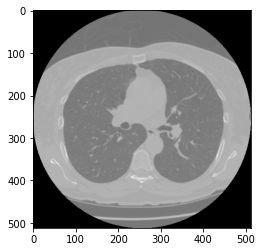

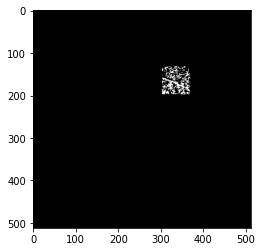

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom as dicom
from os.path import join
from skimage import measure
import pylidc as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import cv2

# source 
id_patient = '0981'
root = 'ct_gan_inpainting/%s/added_ct_gan_inpainting/0/' % id_patient

# id slice
slice_id = 244

# loading data
ds_lunotim = np.load(join(root,'%06d.npy'%slice_id))
mask = np.load(join(root,'%06d_mask.npy'%slice_id))

# show
plt.imshow(ds_lunotim, cmap='gray')
plt.show()
plt.imshow(mask, cmap='gray')
plt.show()

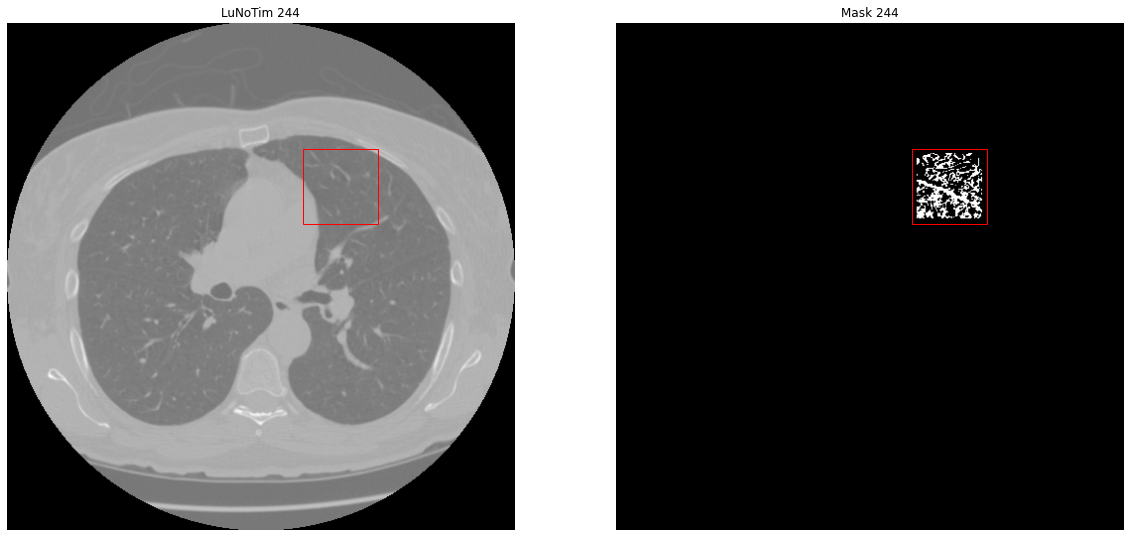

In [13]:

mask_img = mask.astype(np.uint8)  #convert to an unsigned byte
mask_img*=255

kernel = np.ones((11,11), 'uint8')
mask_img = cv2.morphologyEx(mask_img, cv2.MORPH_DILATE, kernel, iterations=1)



contours, _ = cv2.findContours(mask_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


#cv2.drawContours(mask_img, contours, -1, (255, 255, 255), 3)
#epsilon = 0.1*cv2.arcLength(contours[0],True)
#approx = cv2.approxPolyDP(contours[0],epsilon,True)

x,y,w,h = cv2.boundingRect(contours[0])


interp = 'bilinear'
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(20, 20))
axs[0].set_title("LuNoTim %d" % slice_id)
axs[0].imshow(ds_lunotim, interpolation=interp, cmap='gray')
axs[0].axis('off')
rec = Rectangle((x,y), w, h, fc ='none', ec ='r',lw = 1)
axs[0].add_patch(rec)


axs[1].set_title("Mask %d" % slice_id)
axs[1].imshow(mask, interpolation=interp, cmap='gray')
axs[1].axis('off')
rec = Rectangle((x,y), w, h, fc ='none', ec ='r',lw = 1)
axs[1].add_patch(rec)
        
plt.show()


## LIDC dataset

In [14]:
# parameters

pid = 'LIDC-IDRI-'+ id_patient

# query the patient CT scan
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()

images = scan.load_all_dicom_images()

Loading dicom files ... This may take a moment.


Scan(id=674,patient_id=LIDC-IDRI-0981) has 1 nodules.
Nodule 1 has 2 annotations
Loading dicom files ... This may take a moment.
Annotation(id=4709,scan_id=674)
bbox (slice(290, 343, None), slice(178, 227, None), slice(394, 400, None))
Annotation slice =  397


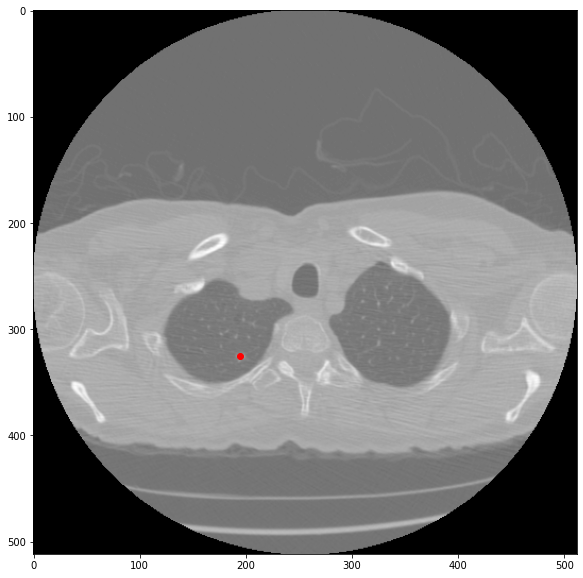

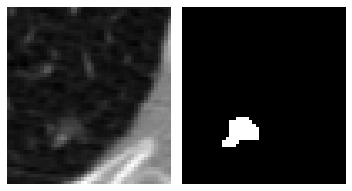

Loading dicom files ... This may take a moment.
Annotation(id=4710,scan_id=674)
bbox (slice(290, 343, None), slice(178, 227, None), slice(394, 400, None))
Annotation slice =  397


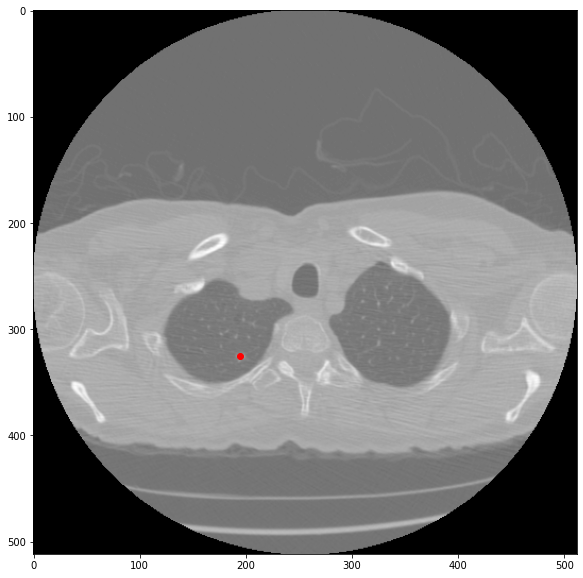

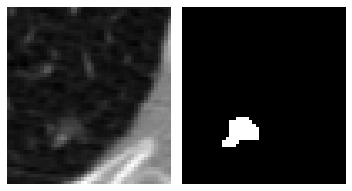

In [15]:
#### Nodules #####

nods = scan.cluster_annotations()
print("%s has %d nodules." % (scan, len(nods)))

for id_n, nod_annots in enumerate(nods):
    #print("Nodule %d has %d annotations - %d masks" % (id_n+1, len(nods[id_n]), count[str(id_n)]))
    print("Nodule %d has %d annotations" % (id_n+1, len(nods[id_n])))
        
    
    for annot in nod_annots:         
        vol = annot.scan.to_volume()
        print(annot)
        padding = [(30,10), (10,25), (0,0)]
        mask_nod = annot.boolean_mask(pad=padding)
        bbox = annot.bbox(pad=padding)
        bmat = annot.bbox_matrix()
        
        print("bbox", bbox)
        
        i,j,k = annot.centroid
        s_id = int(np.round(k))
        print('Annotation slice = ', s_id)       

        # show
        plt.figure(figsize=(10,10))
        plt.imshow( images[s_id].pixel_array, cmap='gray')
        plt.scatter(x=j, y=i, c='r')
        plt.show()
        
        fig,ax = plt.subplots(1,2,figsize=(5,3))
        lim_id = mask_nod.shape[2]-1
        ax[0].imshow(vol[bbox][:,:,lim_id], cmap=plt.cm.gray)
        ax[0].axis('off')
        ax[1].imshow(mask_nod[:,:,lim_id], cmap=plt.cm.gray)
        ax[1].axis('off')
        plt.tight_layout()
        #plt.savefig("../images/mask_bbox.png", bbox_inches="tight")
        plt.show()             

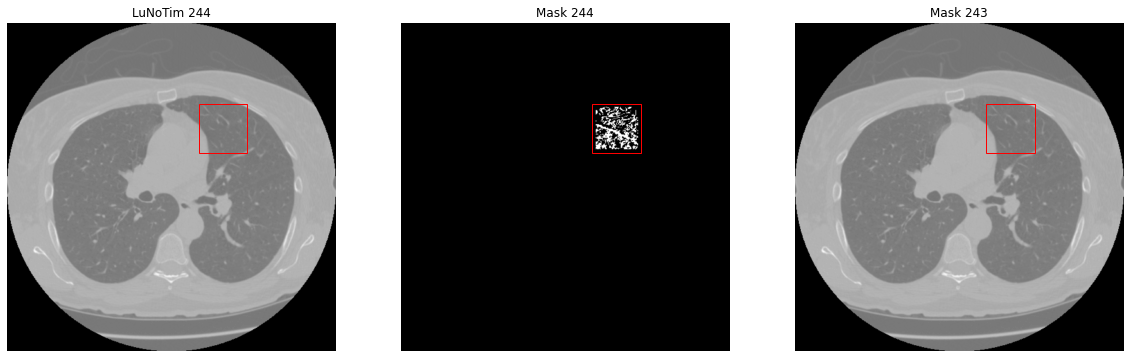

In [16]:
k  = slice_id - 1
ds_lidc =  images[k].pixel_array

interp = 'bilinear'
fig, axs = plt.subplots(1, 3, sharex=True, figsize=(20, 20))
axs[0].set_title("LuNoTim %d" % slice_id)
axs[0].imshow(ds_lunotim, interpolation=interp, cmap='gray')
axs[0].axis('off')
rec = Rectangle((x,y), w, h, fc ='none', ec ='r',lw = 1)
axs[0].add_patch(rec)


axs[1].set_title("Mask %d" % slice_id)
axs[1].imshow(mask, interpolation=interp, cmap='gray')
axs[1].axis('off')
rec = Rectangle((x,y), w, h, fc ='none', ec ='r',lw = 1)
axs[1].add_patch(rec)

axs[2].set_title("Mask %d" % k)
axs[2].imshow(ds_lidc, interpolation=interp, cmap='gray')
axs[2].axis('off')
rec = Rectangle((x,y), w, h, fc ='none', ec ='r',lw = 1)
axs[2].add_patch(rec)

plt.show()